In [27]:
from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [28]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [29]:
os.chdir('/content/drive/MyDrive/Neural_Style_Transfer/')
!ls

images			     output_1500.png  output_3000.png
Neural_Style_Transfer.ipynb  output_2000.png  output_500.png
output_1000.png		     output_2500.png  results


In [30]:
# IDENTIFY CORRECT DEVICE
if torch.backends.mps.is_available():
    dev = "mps"
elif torch.cuda.is_available():
    dev = "cuda"
else:
    dev = "cpu"

device = torch.device(dev)
print(device)

cuda


PREPROCESSING

In [31]:
def load_picture(picture_path, transform=None, max_size=None, shape=None):
   # image --> pytorch tensor
    pic = Image.open(picture_path)

    if max_size:
        scale = max_size / max(pic.size)
        size = np.array(pic.size) * scale
        pic = pic.resize(size.astype(int), Image.ANTIALIAS)

    if shape:
        pic = pic.resize(shape, Image.LANCZOS)

    if transform:
        pic = transform(pic).unsqueeze(0)

    return pic.to(device)

In [32]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)),
])

FEATURE EXTRACTOR

In [40]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.vgg = models.vgg19(pretrained=True).features

    def forward(self, x):
        # Specify layer indices for feature extraction
        layer_indices = [0, 5, 10, 19, 28]
        features = []

        for idx, (name, layer) in enumerate(self.vgg._modules.items()):
            x = layer(x)
            if idx in layer_indices:
                features.append(x)

        return features

CONFIGURATION

In [34]:
lr = 0.003 # default
painting_weight = 100 # default 120
total_steps = 3000 #default 100
print_step = 50 # default total_steps // 10
save_step = 500 # default total_steps // 5
max_size = 400

base = load_picture("./images/colosseo.jpg", transform=transform, max_size = max_size)
painting = load_picture("./images/van_gogh.jpg", transform=transform, shape=[base.size(2), base.size(3)])

goal = base.clone().requires_grad_(True)

In [ ]:
optimizer = torch.optim.Adam([goal], lr=lr, betas=[0.5, 0.999])
net = VGGNet().to(device).eval()

RUN

In [36]:
for step in range(total_steps):
    goal_features = net(goal)
    base_features = net(base)
    painting_features = net(painting)

    painting_loss = 0
    base_loss = 0

    for goal_f, base_f, painting_f in zip(
        goal_features, base_features, painting_features
    ):
        base_loss += torch.mean((goal_f - base_f) ** 2)

        _, c, h, w = base_f.size()
        goal_f = goal_f.reshape(c, -1)
        painting_f = painting_f.reshape(c, -1)

        goal_gram = torch.mm(goal_f, goal_f.t())
        painting_gram = torch.mm(painting_f, painting_f.t())

        painting_loss += torch.mean((goal_gram - painting_gram) ** 2) / (c * h * w)

    loss = base_loss + painting_weight * painting_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



    if (step+1) % print_step == 0:
            print ('Step [{}/{}], Base Loss: {:.4f}, Painting Loss: {:.4f}' .format(step+1, total_steps, base_loss.item(), painting_loss.item()))

    if (step+1) % save_step == 0:
            # Save the generated image
            denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
            pic = goal.clone().squeeze()
            pic = denorm(pic).clamp_(0, 1)
            save_folder = f"./output_{step + 1}.png"

            torchvision.utils.save_image(pic, save_folder)



Step [50/3000], Base Loss: 24.5630, Painting Loss: 864.3602
Step [100/3000], Base Loss: 36.5692, Painting Loss: 427.0555
Step [150/3000], Base Loss: 42.4030, Painting Loss: 276.2441
Step [200/3000], Base Loss: 46.0033, Painting Loss: 201.8086
Step [250/3000], Base Loss: 48.6290, Painting Loss: 156.9292
Step [300/3000], Base Loss: 50.7218, Painting Loss: 126.5202
Step [350/3000], Base Loss: 52.4918, Painting Loss: 104.2102
Step [400/3000], Base Loss: 53.9670, Painting Loss: 87.0119
Step [450/3000], Base Loss: 55.2430, Painting Loss: 73.3202
Step [500/3000], Base Loss: 56.3598, Painting Loss: 62.1740
Step [550/3000], Base Loss: 57.3552, Painting Loss: 52.9729
Step [600/3000], Base Loss: 58.2481, Painting Loss: 45.3381
Step [650/3000], Base Loss: 59.0500, Painting Loss: 38.9988
Step [700/3000], Base Loss: 59.7792, Painting Loss: 33.7412
Step [750/3000], Base Loss: 60.4471, Painting Loss: 29.3973
Step [800/3000], Base Loss: 61.0667, Painting Loss: 25.8208
Step [850/3000], Base Loss: 61.638

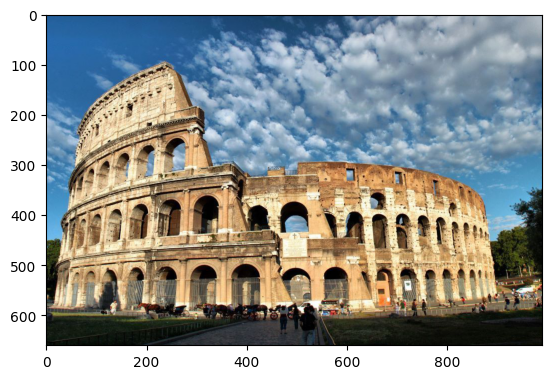

In [37]:
base_orig = mpimg.imread('./images/colosseo.jpg')

# Display the image using Matplotlib
plt.imshow(base_orig)
plt.show()

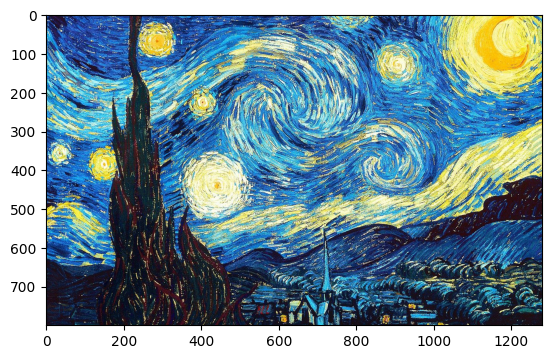

In [38]:
painting_orig = mpimg.imread('./images/van_gogh.jpg')

# Display the image using Matplotlib
plt.imshow(painting_orig)
plt.show()

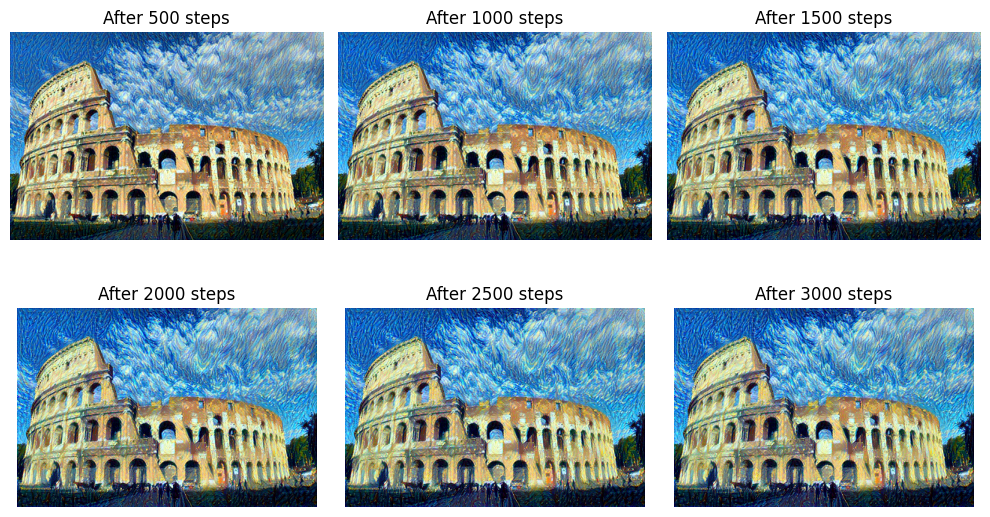

In [39]:
pic1 = mpimg.imread('output_500.png')
pic2 = mpimg.imread('output_1000.png')
pic3 = mpimg.imread('output_1500.png')
pic4 = mpimg.imread('output_2000.png')
pic5 = mpimg.imread('output_2500.png')
pic6 = mpimg.imread('output_3000.png')


# Load the images
img1 = np.array(pic1)
img2 = np.array(pic2)
img3 = np.array(pic3)
img4 = np.array(pic4)
img5 = np.array(pic5)
img6 = np.array(pic6)

# Create a 2 x 3 grid of subplots
fig, ax = plt.subplots(2, 3, figsize=(10, 6), gridspec_kw={'height_ratios': [2, 1]})

# Plot the images in the grid
ax[0, 0].imshow(img1)
ax[0, 0].set_title('After 500 steps')
ax[0, 1].imshow(img2)
ax[0, 1].set_title('After 1000 steps')
ax[0, 2].imshow(img3)
ax[0, 2].set_title('After 1500 steps')
ax[1, 0].imshow(img4)
ax[1, 0].set_title('After 2000 steps')
ax[1, 1].imshow(img5)
ax[1, 1].set_title('After 2500 steps')
ax[1, 2].imshow(img6)
ax[1, 2].set_title('After 3000 steps')

# Hide the axes for a cleaner layout
for i in range(2):
    for j in range(3):
        ax[i, j].axis('off')

plt.tight_layout()

# Save the plot to a PNG file
plt.savefig('./results/colosseo-vangogh.png')

plt.show()